# Create Project

## Libraries and Configurations

In [41]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


# Global importance tools
import joblib
import shap
shap.initjs()

from lime.lime_tabular import LimeTabularExplainer


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

## Functions

In [28]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

# Load the Data joblib

In [29]:
# load the joblib file
loaded_joblib= joblib.load('Models/grocerysales')
loaded_joblib.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [31]:
# save the objects
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
lin_reg = loaded_joblib['LinearRegression']
rf_reg = loaded_joblib['RandomForestRegressor']

In [32]:
## Get feature names from already-fit preprocessor
feature_names = preprocessor.get_feature_names_out()


## Use the preprocessor to transform X_train and X_test
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.22,0.06,61.25,"1,998.00",0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
7604,6.13,0.08,111.29,"2,009.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2762,12.15,0.03,151.07,"2,004.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
6464,5.95,0.09,127.87,"2,004.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
4707,18.20,0.07,247.21,"2,004.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [33]:
## Setting float format for readability
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

In [34]:
# check the X train
len(X_train_df)


6392

In [35]:
# fit the preprocessor
preprocessor.fit(X_train_df,y_train)


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C59C8A2A30>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C59C87E490>)],
                  verbose_feature_names_out=False)

# Global Explanations

In [36]:
# Take a sample of the training data (nsampel=100, use random_state=SEED)
X_shap = shap.sample(X_train_df, nsamples = 100,random_state=SEED)
X_shap.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4469,7.72,0.07,76.40,"1,987.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
4438,5.11,0.03,163.82,"2,004.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
366,8.05,0.08,256.46,"2,004.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [37]:
# look at the  values
X_shap.shape



(100, 1597)

In [38]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

4469   1,402.17
4438   2,120.57
366    5,153.29
2219   2,556.67
6080      83.89
         ...   
8373   2,052.00
5234   1,504.71
4523   3,374.27
2963     397.48
5753   1,662.50
Name: Item_Outlet_Sales, Length: 100, dtype: float64

## Model

In [39]:
# Instantiate a Model Explainer with the model
explainer =shap.TreeExplainer(rf_reg)
explainer

In [40]:
## Getting the shap values
shap_values = explainer.shap_values(X_shap,y_shap,check_additivity=False)
type(shap_values)

numpy.ndarray

In [ ]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


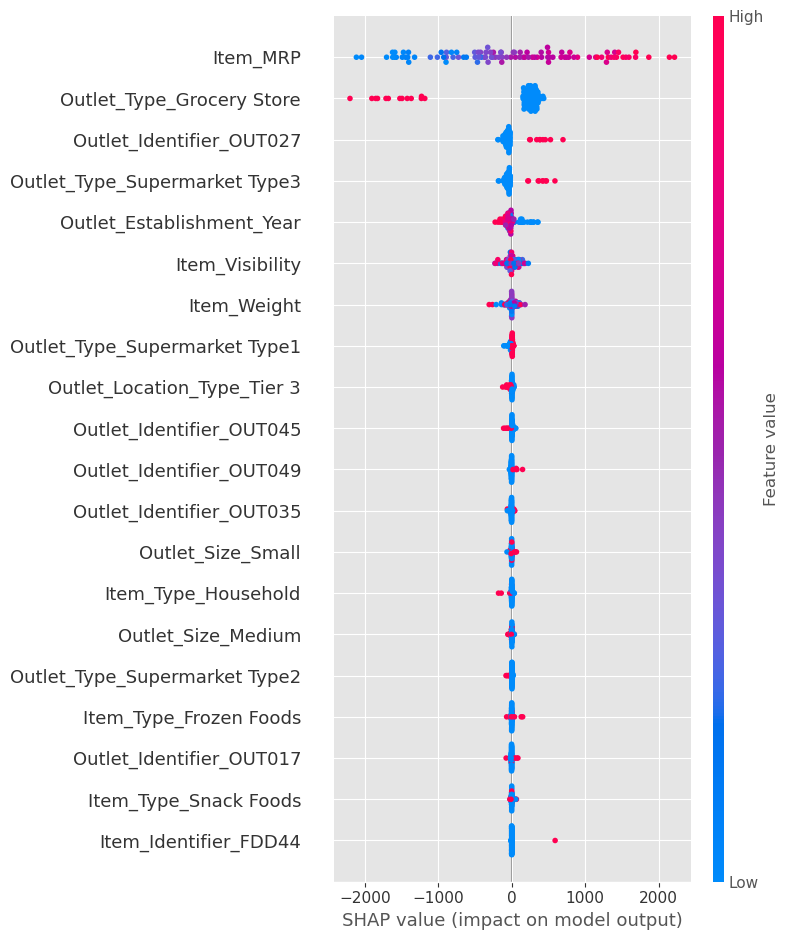

<Figure size 640x480 with 0 Axes>

In [42]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)
plt.savefig('Images/global_summary_plot.png')

### Top 3 Important Features:
- Item MRP
 - The higher item MRP the more likely the model will predict a higher Item Outlet Sale
- Outlet Type Grocery Store
 - Being classified as Outlet type grocery store decreased the likelihood the model will predict a higher Item Outlet Sale
- Outlet Identifier OUT027
 - Outlet identifier OUT027 indicates that the model will predict a higher Item Outlet Sale.

# Local Explanations

In [43]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,7.72,0.07,76.40,"1,987.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
1,5.11,0.03,163.82,"2,004.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
2,8.05,0.08,256.46,"2,004.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
3,8.76,0.05,128.33,"1,999.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4,6.59,0.18,82.79,"1,998.00",0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
